# STOFS Event-based Skill Assessment 
Here we are reading, subsetting and visualizing the forecast and nowcast data from STOFS-2D-Global and STOFS-3D-Atl data. We also read and plot reported water levels at CO-OPS stations. 

In [1]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey

# Add code for hurricane track visualization
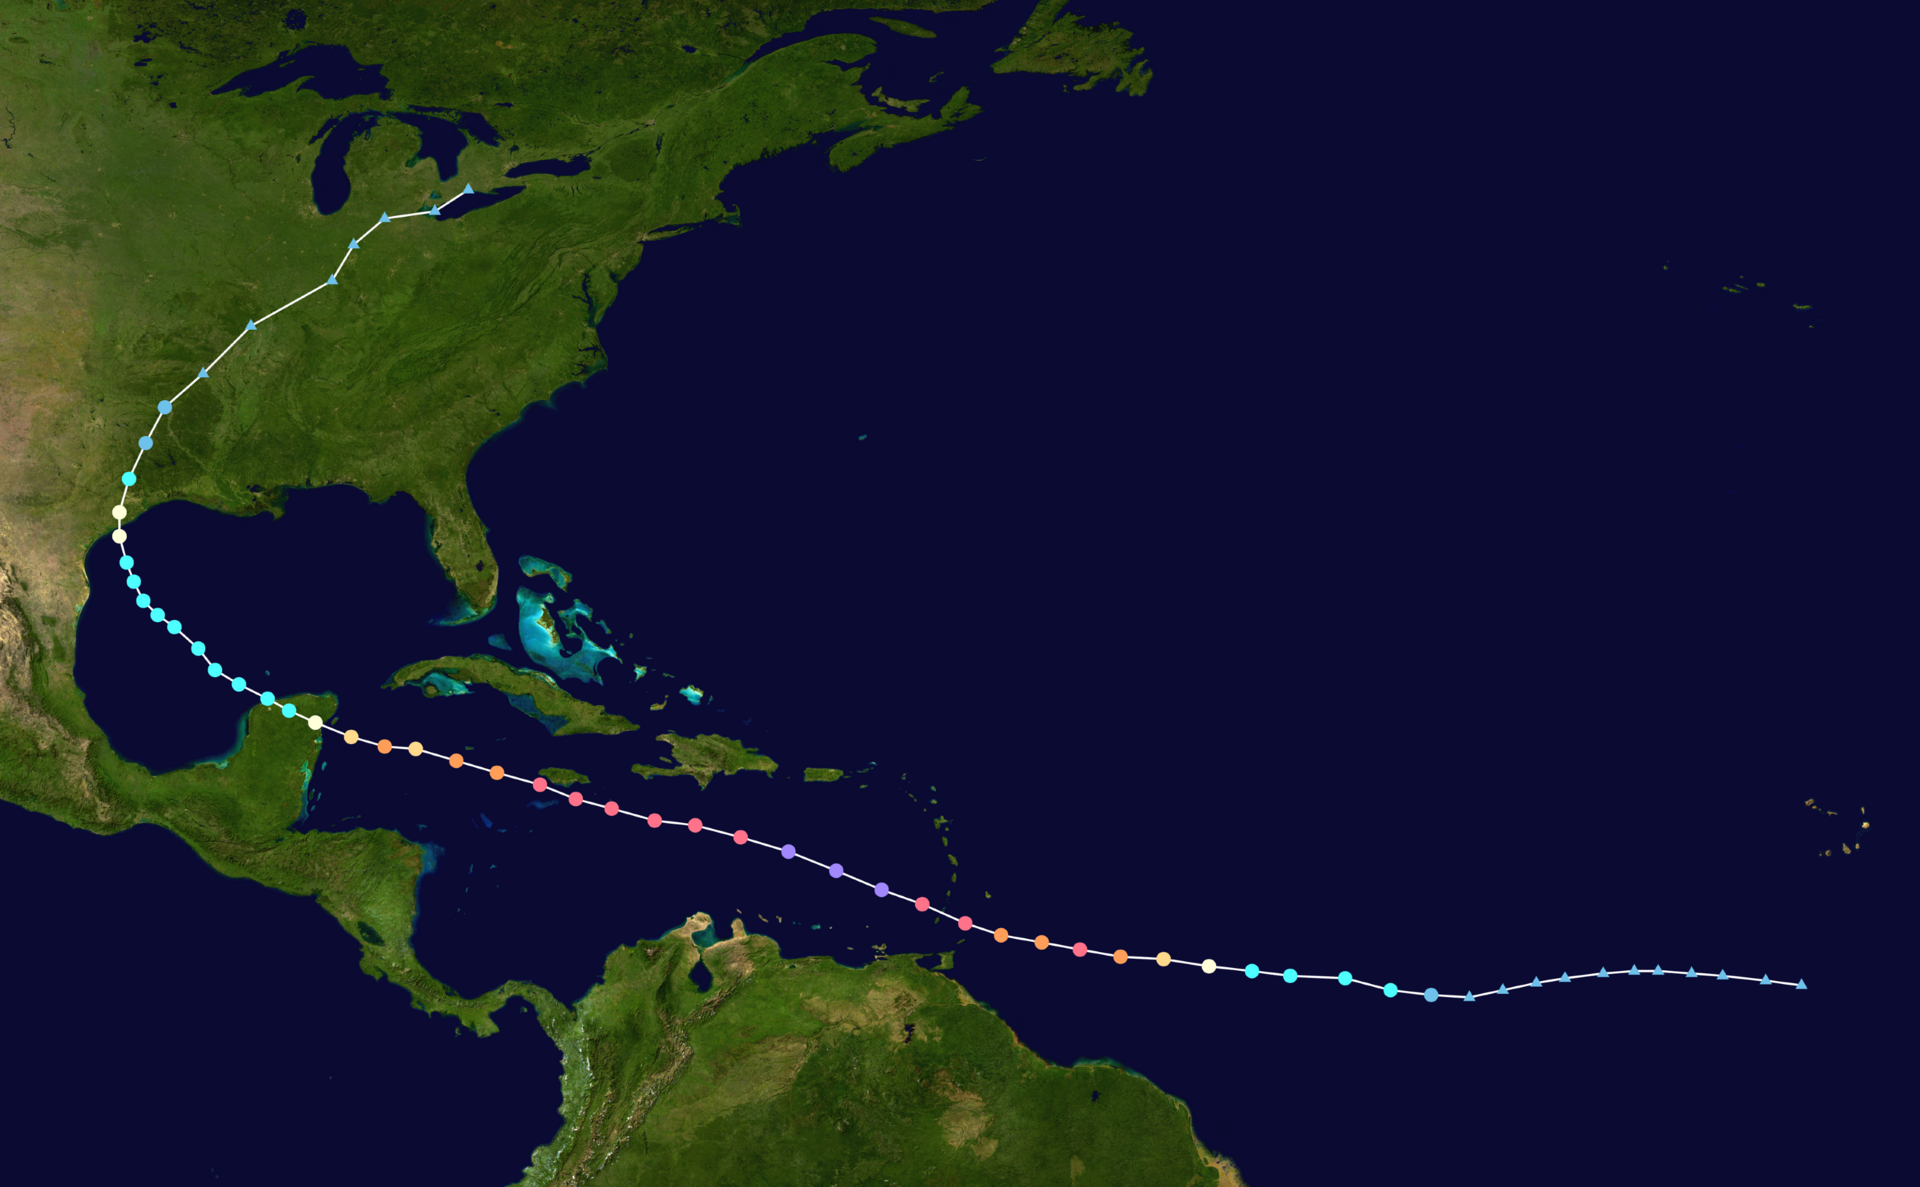
 Hurricane Beryl track (copied from https://en.wikipedia.org/wiki/Hurricane_Beryl).


# Add input information for an specific event- bucket_name_2d: Specifies the name of the S3 bucket where the STOFS-2d-global data is stored.
- bucket_name_3d: Specifies the name of the S3 bucket where the STOFS-3d-Atl data is stored.
- dates: dates in YYYYMMDD format for which we are performing the analysis.
- cycles: List of cycle times in HH format (e.g., 00, 06, 12, 18) indicating the times of day for which STOFS-2d-Global forecasts are generated.
- region: String argument containing bounding box for region of interest (min_lon, max_lon, min_lat, max_lat).
- STOFS_file_2d: STOFS-2d-Global file to be processed (e.g., 'fields.cwl' or 'fields.htp' or 'fields.swl').
- STOFS_file_3d: STOFS-3d-Atl file to be processedes.

In [55]:
# Info of STOFS data

bucket_name_2d   = 'noaa-gestofs-pds'
bucket_name_3d  = 'noaa-nos-stofs3d-pds'
date_range         = ['20240707','20240709']  
landfall_time_step = 320 # minutes after start date 
cycles_2d        = ['00', '06', '12', '18']  # Cycles you want to subset data for.
Region       = (-95.5, -94, 28, 30) #(longitude_min, longitude_max, latitude_min, latitude_max)
Event_name = 'Hurricane Beryl'
STOFS_file_2d   = 'points.cwl'
STOFS_file_3d   = 'points.cwl'


# Read STOFS-2d-Global Nowcast Data on the Fly

In [3]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds



In [4]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
         base_key = f'stofs_2d_glo.{date}'
         filename = f't{cycle}z.{STOFS_file_2d}.nc'
         key = f'{base_key}/stofs_2d_glo.{filename}'
         dataset_2d = read_netcdf_from_s3(bucket_name, key)
         nowcast_2d = dataset_2d.isel(time=slice(0, 60)) # the first 6 hr (60 time steps are the now cast data)
         nowcast_2d_all_list.append(nowcast_2d)
        
nowcast_2d_all = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 120MB
Dimensions:       (time: 960, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 8kB 2024-07-06T18:06:00 ... 2024-07-1...
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 81MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 13MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 13MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 13MB 1.207 0.8957 ... -0.6726 -0.0352
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024070700 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [5]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
         base_key = f'stofs_2d_glo.{date}'
         filename = f't{cycle}z.{STOFS_file_2d}.nc'
         key = f'{base_key}/stofs_2d_glo.{filename}'
         try:
            dataset_2d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_2d is not None:
                nowcast_2d = dataset_2d.isel(time=slice(0, 60))  # First 60 time steps (nowcast data)
                nowcast_2d_all_list.append(nowcast_2d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')

nowcast_2d_all_out_of_range = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all = nowcast_2d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_2d_all

<xarray.Dataset> Size: 90MB
Dimensions:       (time: 721, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-07-07 ... 2024-07-10
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 61MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 10MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 10MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 10MB -0.891 -0.6393 ... 1.024 -0.1225
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024070700 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Read STOFS-3d-Atlantic Nowcast Data on the Fly

In [6]:
# Read STOFS-3d-Atlantic

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_3d_all_list = []
for date in dates:
         base_key = f'stofs_3d_atl.{date}'
         filename = 't12z.points.cwl.nc'
         key = f'STOFS-3D-Atl/{base_key}/stofs_3d_atl.{filename}'
         try:
            dataset_3d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_2d is not None:
                nowcast_3d = dataset_3d.isel(time=slice(0, 240))  # the first 24 hr (240 time steps are the now cast data)
                nowcast_3d_all_list.append(nowcast_3d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')
       

nowcast_3d_all_out_of_range = xr.concat(nowcast_3d_all_list, dim='time')

nowcast_3d_all = nowcast_3d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_3d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 8MB
Dimensions:       (time: 721, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-07-07 ... 2024-07-10
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 623kB -1.845 -1.11 ... 0.0653 0.4791
    station_name  (time, station) |S50 4MB b'PSBM1 SOUS41 8410140 ME Eastport...
    x             (time, station) float64 623kB 44.9 44.66 43.66 ... 26.06 27.83
    y             (time, station) float64 623kB -66.98 -67.2 ... -97.22 -97.49
    u             (time, station) float64 623kB -0.7698 -0.1099 ... -999.0
    v             (time, station) float64 623kB -0.6133 0.06315 ... -999.0
    salinity      (time, station) float64 623kB 28.64 31.99 ... 32.37 -999.0
    temperature   (time, station) float64 623kB 11.89 10.4 ... 29.99 -999.0
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Sun Jul  7 18:04:48 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

# Find all the CO-OPs stations in the region using searvey

In [7]:
bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9))
station_ds

<xarray.Dataset> Size: 179kB
Dimensions:  (t: 721, nos_id: 10)
Coordinates:
  * t        (t) datetime64[ns] 6kB 2024-07-07 ... 2024-07-10
  * nos_id   (nos_id) object 80B '8771972' '8772471' ... '8770777' '8771450'
    nws_id   (nos_id) <U5 200B 'LUIT2' 'FPST2' 'EPTT2' ... 'NCHT2' 'GTOT2'
    x        (nos_id) float64 80B -95.11 -95.29 -94.92 ... -94.99 -95.27 -94.79
    y        (nos_id) float64 80B 29.09 28.94 29.48 29.51 ... 29.68 29.73 29.31
Data variables:
    v        (nos_id, t) float32 29kB 1.48 1.482 1.482 ... 1.751 1.746 1.739
    s        (nos_id, t) float32 29kB 0.008 0.008 0.007 ... 0.002 0.003 0.002
    f        (nos_id, t) object 58kB '1,0,0,0' '1,0,0,0' ... '0,0,0,0' '0,0,0,0'
    q        (nos_id, t) object 58kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p' 'p'

# Find CO-OPS station in STOFS-2D-Global station list

In [21]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Calculate the number of 6-minute data points in one hour
data_points_per_hour = 60 / 6  # 10 data points per hour

# Loop over stations and extract zeta if any search string is found in the station name

for station_index in range(len(nowcast_2d_all.station)):
    station_name = nowcast_2d_all.station_name[0,station_index].item().decode('utf-8').strip()  
    for nos_id in station_ds['nos_id']:
        if (nos_id.item() in station_name):
           zeta_values = nowcast_2d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = nowcast_2d_all.x[0, station_index]
           y = nowcast_2d_all.y[0, station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id.item())
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values = np.concatenate(zeta_values_list, axis=0)

all_zeta_values = np.reshape(all_zeta_values, (int(len(all_zeta_values)/len(nowcast_2d_all.time)),len(nowcast_2d_all.time)))
nos_id_points

['8770613',
 '8770777',
 '8770971',
 '8771013',
 '8771341',
 '8771450',
 '8770808',
 '8771486',
 '8771972']

# Plot the stations for STOFS-2d-Global


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
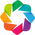

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [22]:
hv.extension("bokeh")

# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

stations = (x_values,y_values)
kb = gv.Points(stations).opts(color="red", marker="circle_dot", size=5)


layout = tiles * kb 
layout

# Find CO-OPS station in STOFS-3D-Atlantic station list

In [18]:
# Create an empty list to collect zeta values
zeta_values_list_3d = []
nos_id_points_3d = []
x_values_3d = []
y_values_3d = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

for station_index in range(len(nowcast_3d_all.station)):
    station_name = nowcast_3d_all.station_name[0,station_index].item().decode('utf-8').strip()  
    for nos_id in station_ds['nos_id']:
        if (nos_id.item() in station_name):
           zeta_values = nowcast_3d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = station_ds['x'][station_ds['nos_id']==nos_id]
           y = station_ds['y'][station_ds['nos_id']==nos_id]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id.item())
           zeta_values_list_3d.append(zeta_values)
           x_values_3d.append(x.item())
           y_values_3d.append(y.item())
           names_3d.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values_3d = np.concatenate(zeta_values_list_3d, axis=0)

all_zeta_values_3d = np.reshape(all_zeta_values_3d, ( int(len(all_zeta_values_3d)/len(nowcast_3d_all.time)),len(nowcast_3d_all.time)))
nos_id_points_3d

['8770613',
 '8770777',
 '8770808',
 '8770971',
 '8771341',
 '8771450',
 '8771486',
 '8771972']

In [17]:
all_zeta_values_3d.shape

(721, 8)

In [11]:
names_3d

['MGPT2 SOUS42 8770613 TX Morgans',
 'NCHT2 SOUS42 8770777 TX Manchester',
 'HIST2 SOUS42 8770808 TX High',
 'RLOT2 SOUS42 8770971 TX Rollover',
 'GNJT2 SOUS42 8771341 TX Galveston',
 'GTOT2 SOUS42 8771450 TX Galveston',
 'GRRT2 SOUS42 8771486 TX Galveston',
 'LUIT2 SOUS42 8771972 TX San Luis Pass']

# Plot the stations for STOFS-3d-Atlantic

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
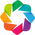

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [12]:
hv.extension("bokeh")
# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles_3d =  api.get_tiles() 

stations_3d = (x_values_3d,y_values_3d)
kb_3d = gv.Points(stations_3d).opts(color="red", marker="circle_dot", size=5)


layout_3d = tiles_3d * kb_3d 
layout_3d

# Read Observation data for STOFS-2D-Global

In [33]:

# Initialize an empty DataFrame to store the data
Observation = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      

       # Add the data for the current station to the result DataFrame
       Observation.append(station_df['v'].values)



# Read Observation data for STOFS-3D-Atlantic

In [34]:
# Initialize an empty DataFrame to store the data
Observation_3d = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d.append(station_df['v'].values)



# Plot Time series STOFS-2D-Global

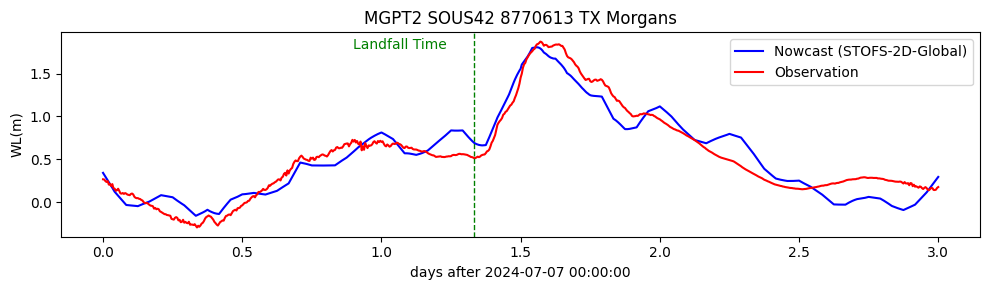

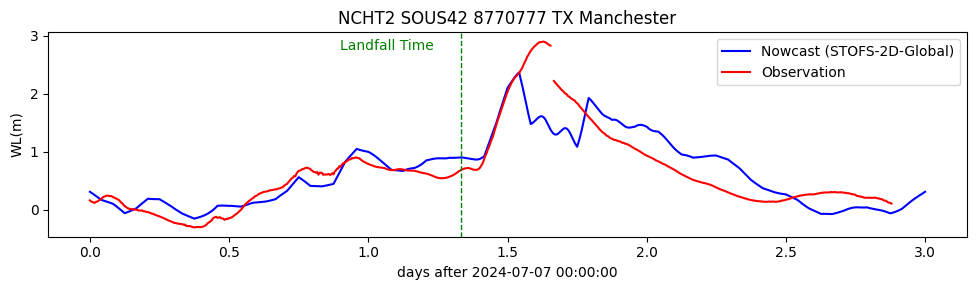

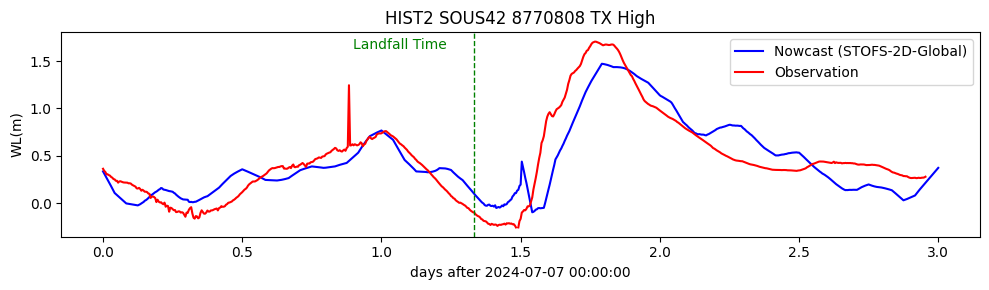

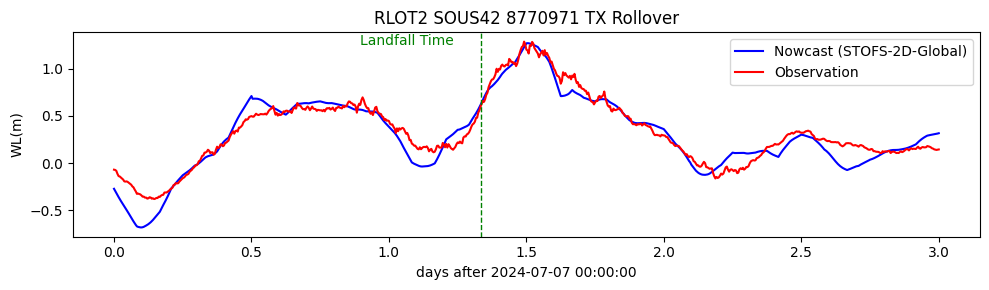

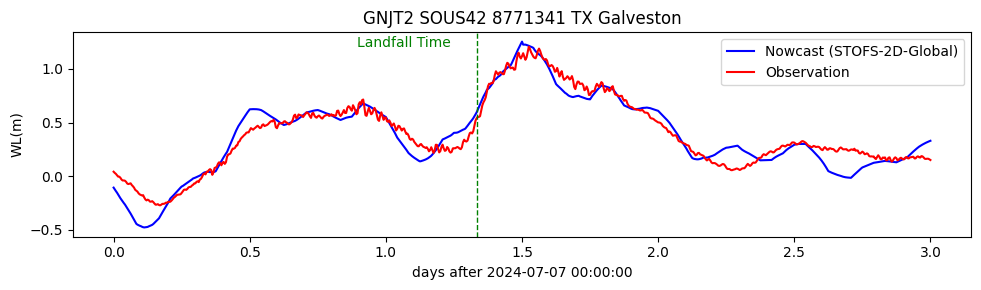

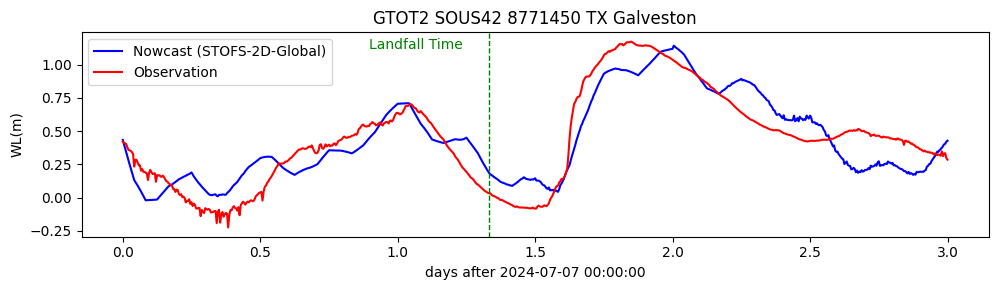

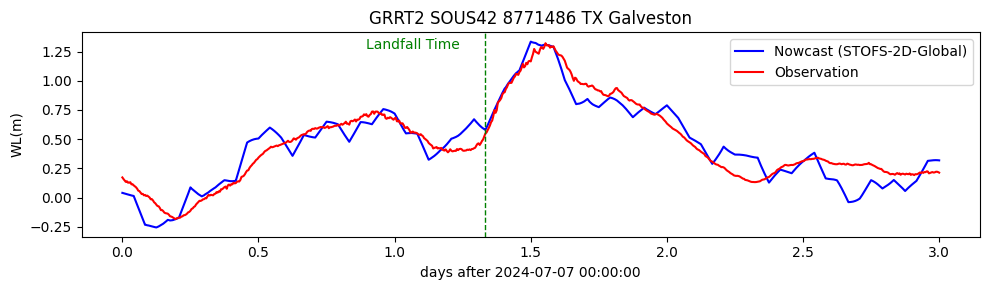

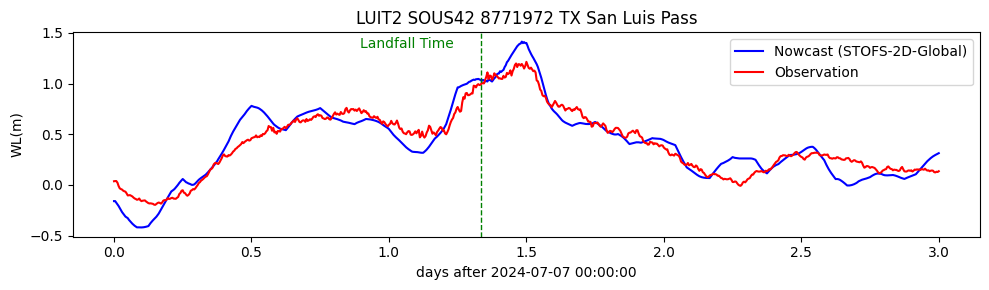

In [54]:
index = 0
index_3d = 0 
for nos_id in nos_id_points:
    
    if nos_id in nos_id_points_3d:
       fig, ax = plt.subplots(figsize=(10, 3))
       
       ax.plot(all_zeta_values[index,:], label='Nowcast (STOFS-2D-Global)', color='blue')
       ax.plot(Observation[index][0], label='Observation', color='red')
       ax.set_title(names_3d[index_3d])
       ax.set_xlabel(f'days after {start_date}')
       ax.set_xticks(range(0, len(all_zeta_values[index, :]), 120))  
       ax.set_xticklabels([str(x/2) for x in range(len(ax.get_xticks()))]) 

       
       ax.axvline(x=landfall_time_step, color='green', linestyle='--', linewidth=1)
       ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.9, 'Landfall Time', color='green', ha='center')
        
       ax.set_ylabel('WL(m)')
       ax.legend()
       plt.tight_layout()
       plt.show()
       index_3d = index_3d+1 
    index = index+1


# Plot Time series STOFS-3D-Atlantic

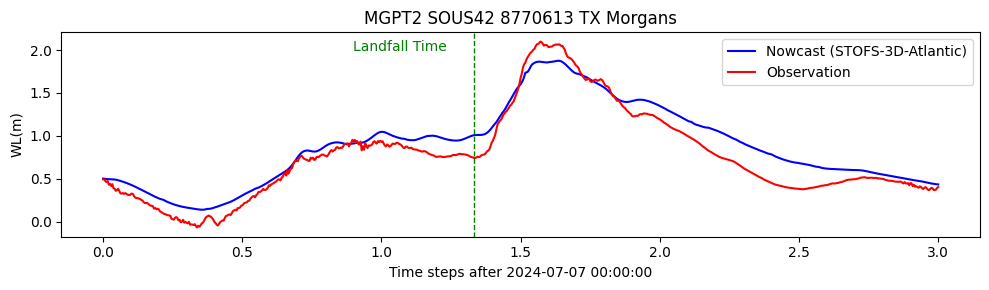

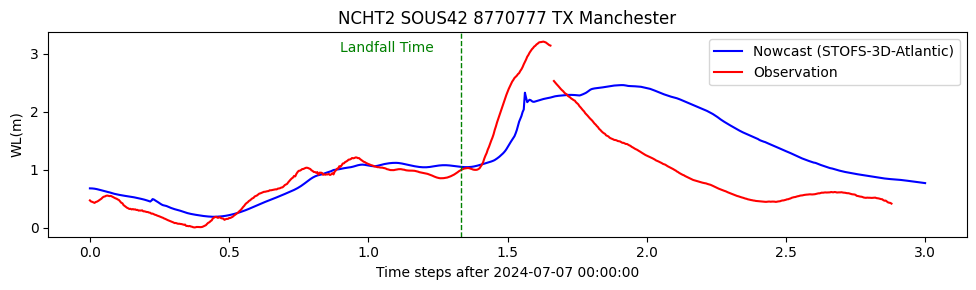

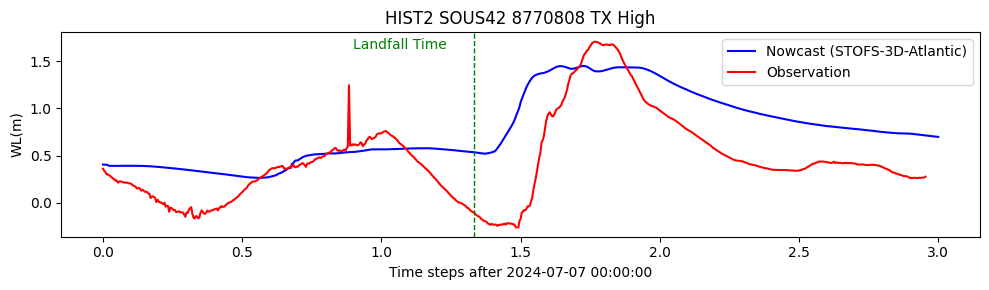

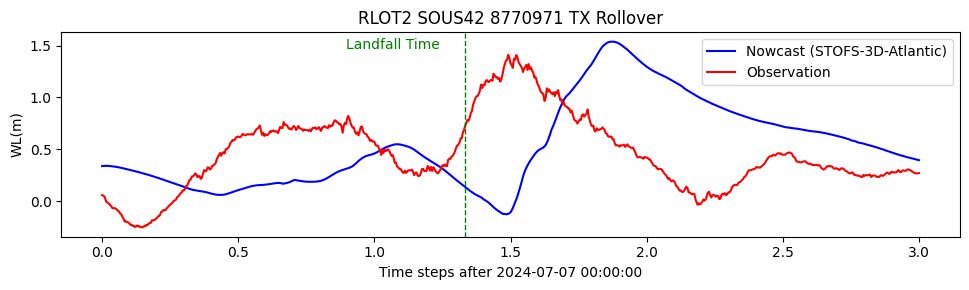

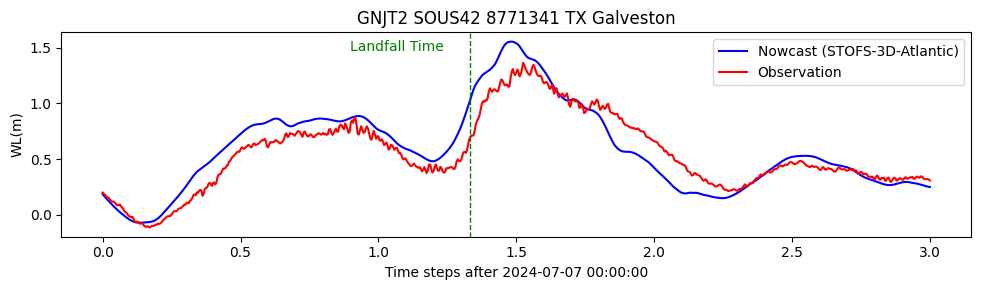

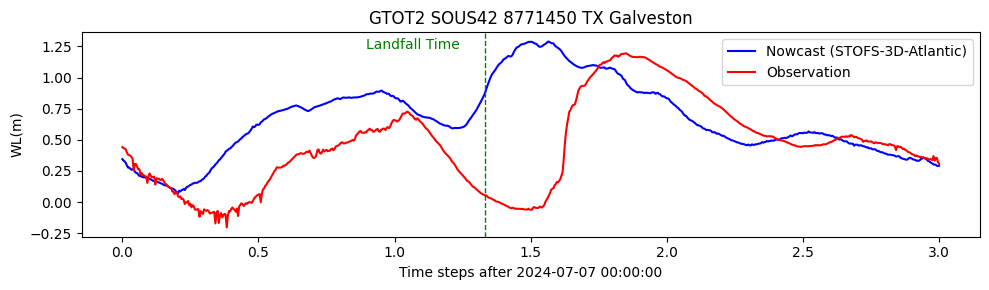

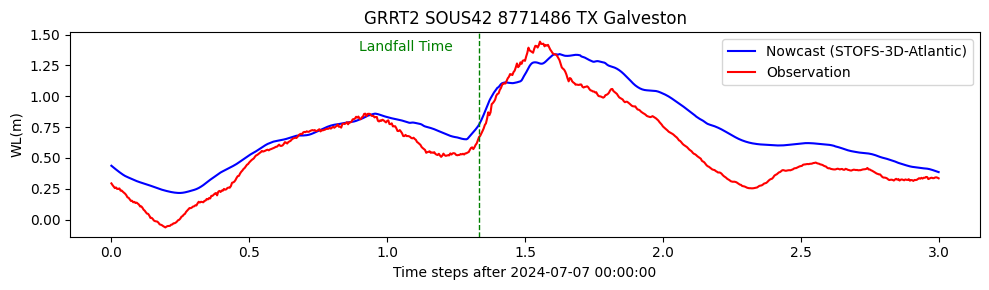

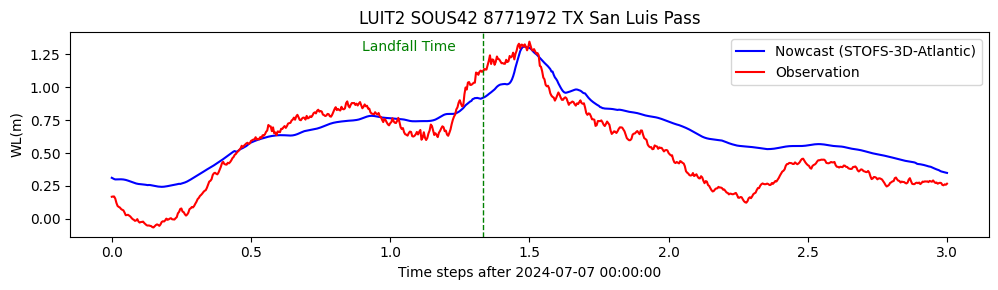

In [57]:
index = 0
index_3d = 0 
for nos_id in nos_id_points:
    
    if nos_id in nos_id_points_3d:
       fig, ax = plt.subplots(figsize=(10, 3))
       
       ax.plot(all_zeta_values_3d[index_3d,:], label='Nowcast (STOFS-3D-Atlantic)', color='blue')        
       ax.plot(Observation_3d[index][0], label='Observation', color='red')
       ax.set_title(names_3d[index_3d])
       ax.set_xlabel(f'Time steps after {start_date}')

       ax.set_xticks(range(0, len(all_zeta_values[index, :]), 120))  
       ax.set_xticklabels([str(x/2) for x in range(len(ax.get_xticks()))])
        
       ax.axvline(x=landfall_time_step, color='green', linestyle='--', linewidth=1)
       ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.9, 'Landfall Time', color='green', ha='center')
       ax.set_ylabel('WL(m)')
       ax.legend()
       plt.tight_layout()
       plt.show()
       index_3d = index_3d+1 
    index = index+1